<a href="https://colab.research.google.com/github/Cksdud123/colab/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import numpy as np
import pandas as pd
import glob
import os
import shutil
import zipfile
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
from datetime import datetime, time
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
import cv2
from keras.applications.vgg19 import VGG19
from keras.regularizers import l2
from keras.datasets import cifar10
from keras.utils import to_categorical

In [3]:
# 소스 파일 경로
source_file_path = '/content/drive/MyDrive/Colab Notebooks/archive.zip'

# 대상 파일 경로
target_file_path = '/content/archive.zip'

# 파일 복사
shutil.copyfile(source_file_path, target_file_path)

# ZIP 파일 경로
zip_file_path = '/content/archive.zip'

# 언집할 폴더 경로
target_folder_path = '/content/dataset'

# ZIP 파일 언집
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder_path)

In [4]:
def csv_to_df(split_type, bearing):
    colname = ['Hour' , 'Minute' , 'Second', 'microsecond', 'Horiz', 'Vert']

    # CSV 파일들이 있는 디렉토리 경로
    directory_path = f'/content/dataset/ieee-phm-2012-data-challenge-dataset-master/{split_type}/{bearing}'

    # 디렉토리 내의 모든 CSV 파일 경로를 가져오기
    file_paths = glob.glob(directory_path + '/*.csv')

    # 파일 경로를 순서대로 정렬
    file_paths = sorted(file_paths)

    # 파일들을 담을 빈 DataFrame 생성
    combined_data = pd.DataFrame()

    # acc 파일만 불러오기 (파일명에 'acc'가 포함된 파일들)
    acc_file_paths = [file_path for file_path in file_paths if 'acc' in file_path]

    # 각 파일을 순회하며 데이터를 불러온 뒤 빈 DataFrame에 추가
    for file_path in acc_file_paths:
        df = pd.read_csv(file_path, names=colname, header=None)  # 첫 번째 행을 인덱스로 사용하지 않음
        combined_data = pd.concat([combined_data, df], ignore_index=True, axis=0)

    return combined_data

In [5]:
def convert_timestamp(df):
    # Convert timestamp columns to integers and create a new DataFrame with these values
    timestamp_integers = df[['Hour' , 'Minute' , 'Second', 'microsecond']].astype(int)
    timestamp_integers.columns = ['hour', 'minute', 'second', 'microsecond']

    # Combine the integer values to form a string in the format 'HH:MM:SS.microseconds'
    df['timestamp'] = timestamp_integers.apply(lambda x: f"{x['hour']:02d}:{x['minute']:02d}:{x['second']:02d}.{x['microsecond']:06d}", axis=1)

    # Convert the 'timestamp' column to a Pandas datetime object
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')

    # Remove the date part from the 'timestamp' column
    df['timestamp'] = df['timestamp'].dt.time

    df = df.drop(['Hour' , 'Minute' , 'Second', 'microsecond'], axis=1)

    return df

In [6]:
def make_dataframe(split_type, bearing):
    df = csv_to_df(split_type, bearing)
    df = convert_timestamp(df)
    return df

In [7]:
Learning_Bearing1_1 = make_dataframe('Learning_set', 'Bearing1_1')
#Learning_Bearing1_2 = make_dataframe('Learning_set', 'Bearing1_2')
#Learning_Bearing2_1 = make_dataframe('Learning_set', 'Bearing2_1')
#Learning_Bearing2_2 = make_dataframe('Learning_set', 'Bearing2_2')
#Learning_Bearing3_1 = make_dataframe('Learning_set', 'Bearing3_1')
#Learning_Bearing3_2 = make_dataframe('Learning_set', 'Bearing3_2')

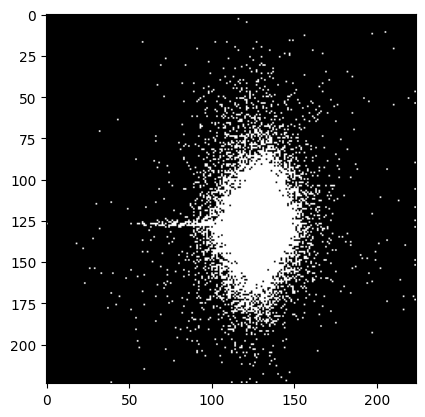

In [11]:
def convert_to_image(df):
    # Normalize the vibration data to the range [0, 255] to represent it as an 8-bit grayscale image
    min_value = df[['Horiz', 'Vert']].min().min()
    max_value = df[['Horiz', 'Vert']].max().max()
    df['Horiz'] = ((df['Horiz'] - min_value) / (max_value - min_value)) * 255
    df['Vert'] = ((df['Vert'] - min_value) / (max_value - min_value)) * 255
    # Create a blank 224x224x3 RGB image
    image = np.zeros((224, 224, 3), dtype=np.uint8)
    # Fill the image with the vibration data
    for _, row in df.iterrows():
        x = int(np.clip(row['Horiz'], 0, 223))
        y = int(np.clip(row['Vert'], 0, 223))
        image[x, y, 0] = 255
        image[x, y, 1] = 255
        image[x, y, 2] = 255
    return image
def resize_image(image):
    # Resize the image to 224x224
    resized_image = cv2.resize(image, (224, 224))
    return resized_image
# Convert the vibration data to an image and resize it
learning_image = convert_to_image(Learning_Bearing1_1)
resized_learning_image = resize_image(learning_image)
# Display the resized image
plt.imshow(resized_learning_image)
plt.show()